In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import IPython.display

In [3]:
sys.path.insert(0, "/home/mai/zkhan/ALBEF")

In [4]:
import matplotlib.pyplot as plt
import skimage.io
from matplotlib.patches import Polygon
import cv2
import random
import colorsys
import os
from torch import nn
from skimage.measure import find_contours

In [5]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

In [6]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [7]:
def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [8]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
from models.tokenization_bert import BertTokenizer
from models.singlestream_v2.baseline_retrieval import ALBEF
from models.vit import interpolate_pos_embed

In [10]:
import json
import random
import ruamel.yaml as yaml
from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
import spacy

In [11]:
nlp = spacy.load('en_core_web_sm')

In [12]:
from dataset.utils import pre_caption

In [13]:
with open('/net/acadia10a/data/zkhan/cc12m-json/100k.json', 'r') as f:
    cc100k = json.load(f)

In [14]:
IMAGE_RES = 1536

In [15]:
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
test_transform = transforms.Compose([
        transforms.Resize((IMAGE_RES,IMAGE_RES),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        normalize,
])

view_transform = transforms.Compose([
        transforms.Resize((IMAGE_RES, IMAGE_RES),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
])



with open('../configs/ablations/Pretrain4M_SharedTxtEncoder.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.Loader)
# patch the BERT config to be an absolute path because we're running
# the code from a different directory
config['bert_config'] = '/home/mai/zkhan/ALBEF/configs/shared_bert.json'
config['image_res'] = IMAGE_RES

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = ALBEF(config=config, text_encoder='bert-base-uncased', tokenizer=tokenizer, init_deit=True)
checkpoint = torch.load(
    '/net/acadia10a/data/zkhan/ALBEF-checkpoints/ablations/shared_txt_enc_pseudolabels_multimodal_mim_momentum/checkpoint_29.pth',
    map_location='cpu'
)
state_dict = checkpoint['model']
for key in list(state_dict.keys()):
    if 'bert' in key:
        encoder_key = key.replace('bert.','')         
        state_dict[encoder_key] = state_dict[key] 
        del state_dict[key]    
pos_embed_reshaped = interpolate_pos_embed(
    state_dict['visual_encoder.pos_embed'], model.visual_encoder
)         
state_dict['visual_encoder.pos_embed'] = pos_embed_reshaped
m_pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder_m.pos_embed'],model.visual_encoder_m)   
state_dict['visual_encoder_m.pos_embed'] = m_pos_embed_reshaped 
msg = model.load_state_dict(state_dict,strict=False) 

device = torch.device('cuda')
model.eval();
model = model.to(device)

/home/mai/zkhan/miniconda3/envs/ssl/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


reshape position embedding from 196 to 9216
_IncompatibleKeys(missing_keys=['mask_token'], unexpected_keys=['head.weight', 'head.bias'])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.pooler.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from t

Some weights of BertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.11.crossattention.self.value.weight', 'bert.encoder.layer.7.crossattention.self.value.weight', 'bert.encoder.layer.7.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.4.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.4.crossattention.self.value.weight', 'bert.encoder.layer.4.crossattention.self.value.bias', 'bert.encoder.layer.6.crossattention.self.query.weight', 'bert.encoder.layer.6.crossattention.self.value.bias', 'bert.encoder.layer.1.crossattention.self.value.bias', 'bert.encoder.layer.5.crossattention.self.query.weight', 'bert.encoder.layer.9.crossattention.output.dense.bias', 'bert.encoder.layer.5.crossattention.self.query.bias', 'bert.encoder.layer.10.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.9.crossattention.self.query.weight', 'bert.encoder.layer.1.crossattention.self.query.bias', 'bert.encoder.lay

reshape position embedding from 256 to 9216
reshape position embedding from 256 to 9216


The photo that started it all! Snowy Owl on Crane Beach, Ipswich, MA in 2015.


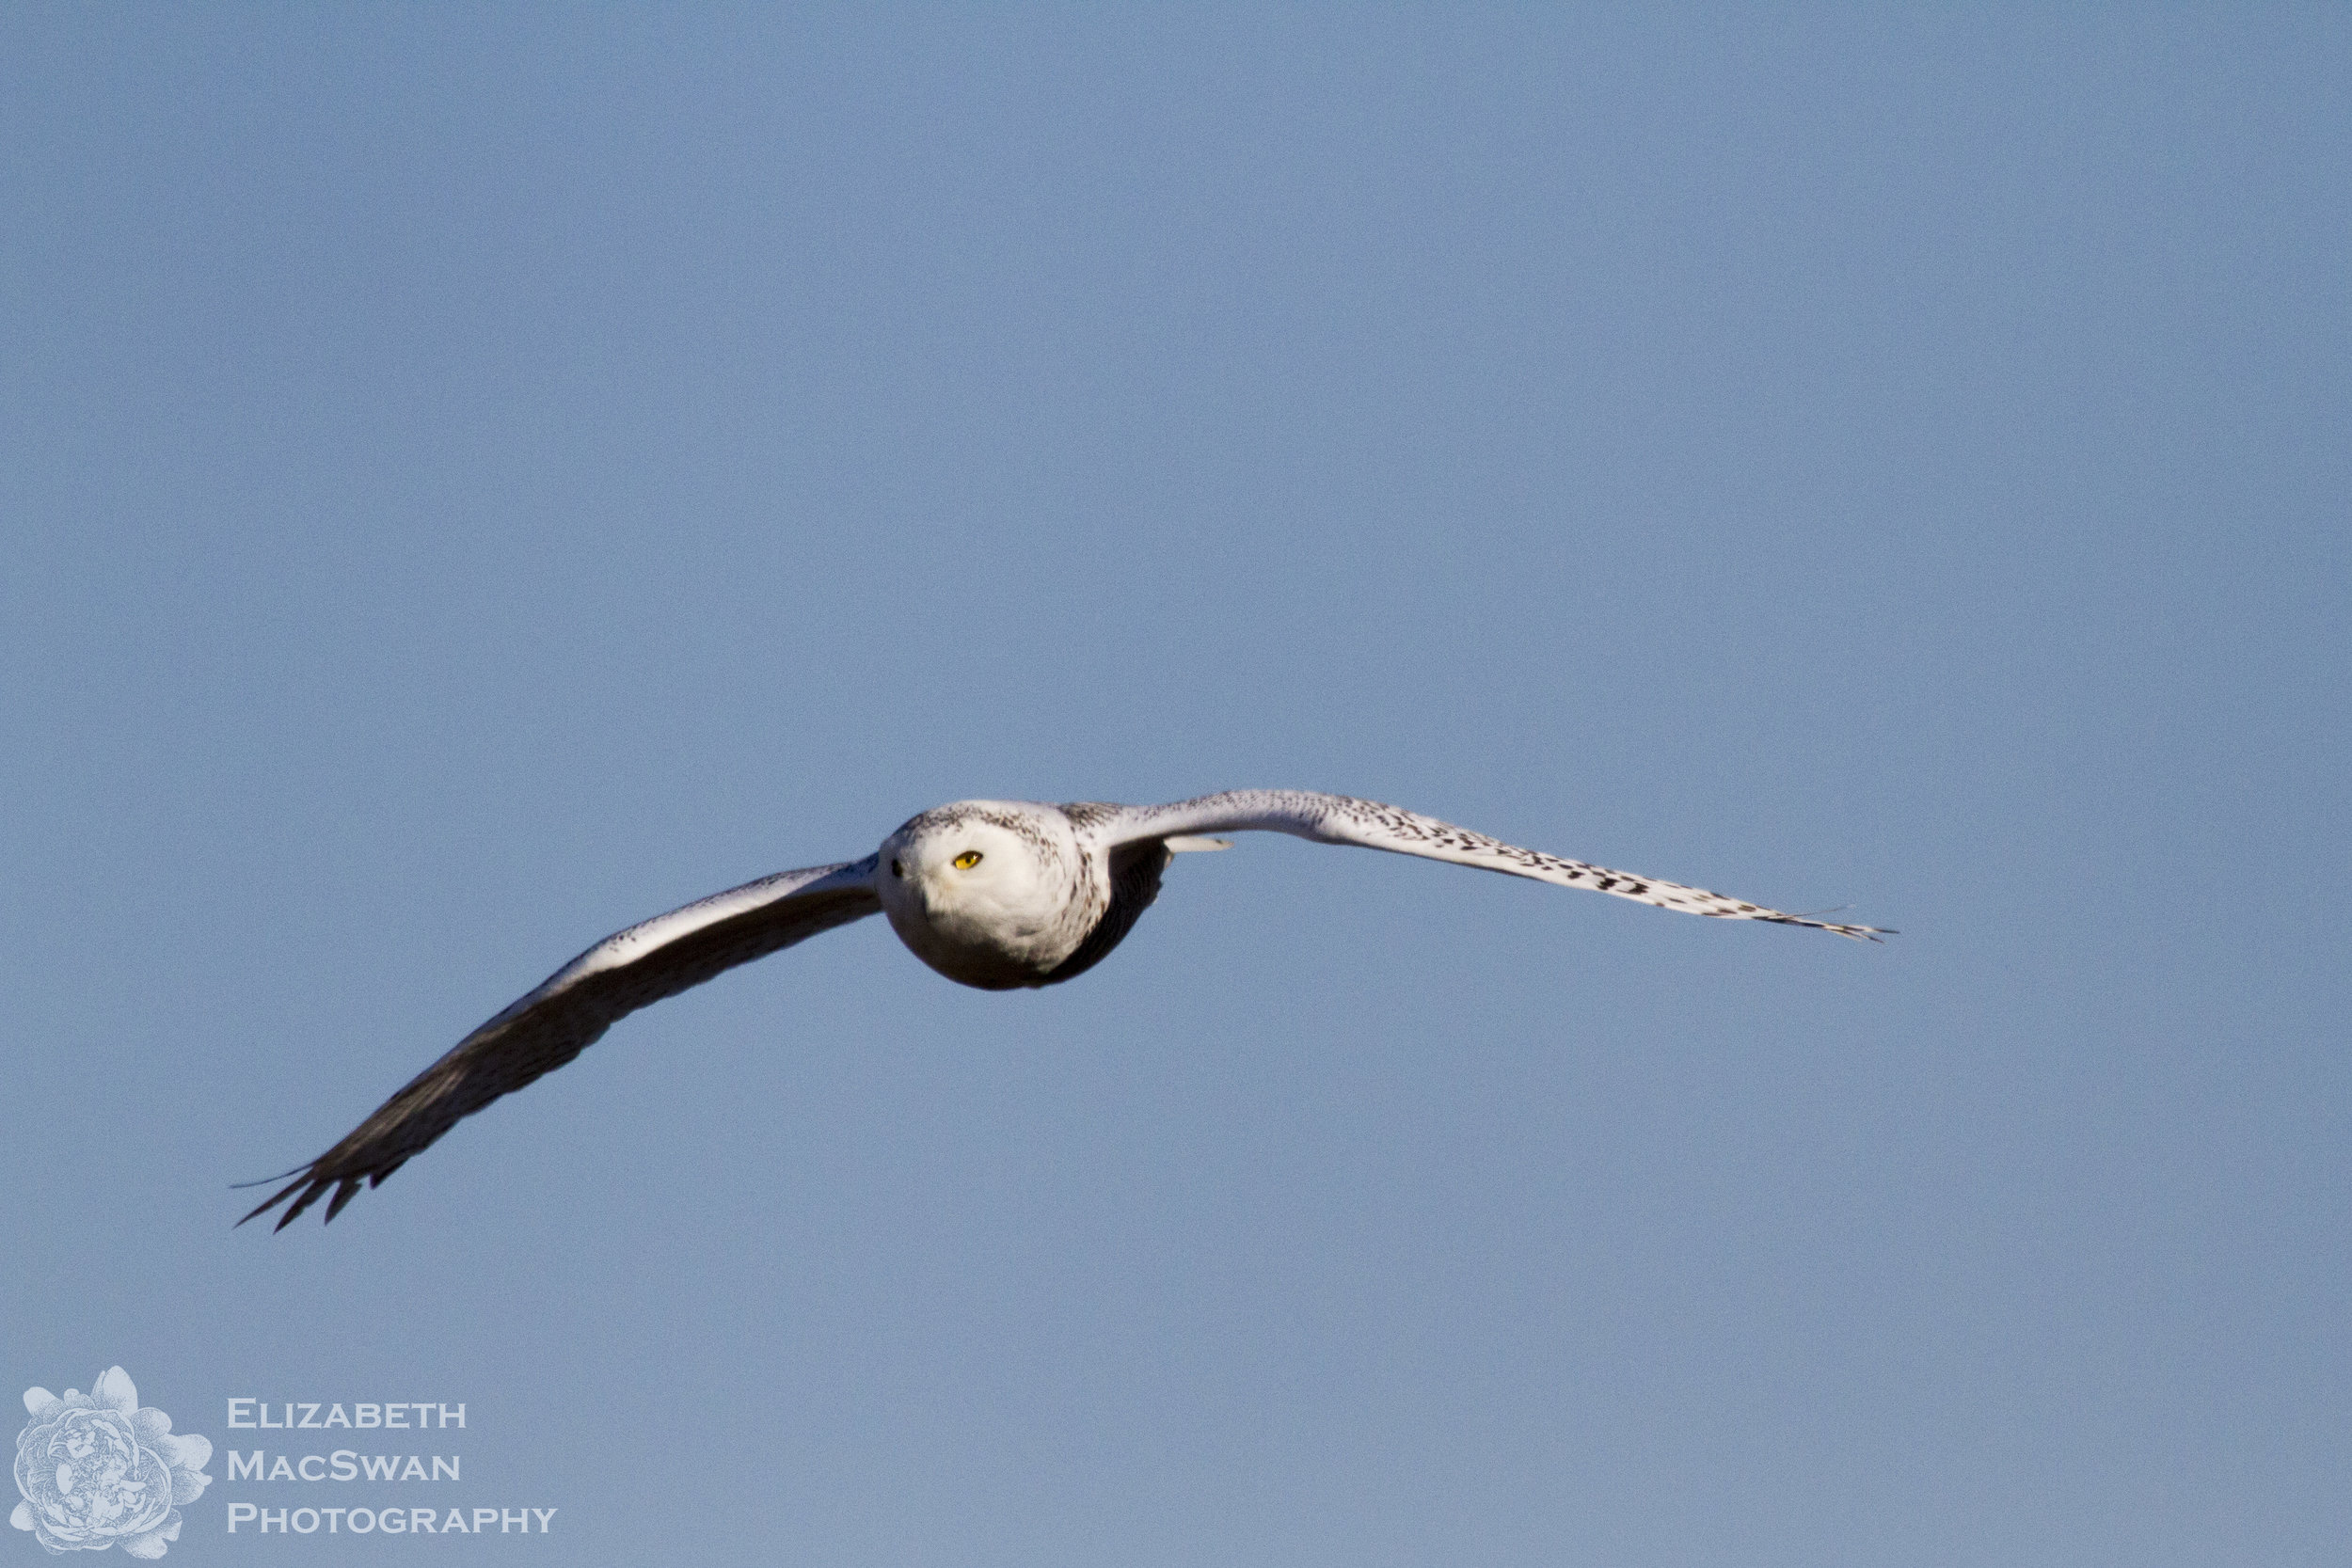

In [23]:
sample = random.choice(cc100k)
print(sample['caption'])
IPython.display.Image(sample['image'], width=300)

In [24]:
image = test_transform(Image.open(sample['image']).convert('RGB'))
view_image = view_transform(Image.open(sample['image']).convert('RGB'))

In [25]:
caption = pre_caption(sample['caption'], 30)
caption

'the photo that started it all snowy owl on crane beach ipswich ma in 2015'

In [26]:
image = image.to(device)

In [27]:
text = tokenizer(caption, padding='longest', truncation=True, max_length=25, return_tensors="pt").to(device)

In [28]:
image_embeds = model.visual_encoder(image.unsqueeze(0), register_blk=11)
image_embeds.shape

RuntimeError: CUDA out of memory. Tried to allocate 3.80 GiB (GPU 0; 47.54 GiB total capacity; 42.12 GiB already allocated; 3.58 GiB free; 42.33 GiB reserved in total by PyTorch)

In [ ]:
self_att_i = model.visual_encoder.blocks[11].attn.get_attention_map()
self_att_i.shape

In [ ]:
nh = self_att_i.shape[1]
attentions = self_att_i[0, :, 0, 1:].reshape(nh, -1).cpu()

In [ ]:
PATCH_SZ = 16
N_PATCHES = IMAGE_RES // PATCH_SZ
threshold = 0.8
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, N_PATCHES, N_PATCHES).float()
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=PATCH_SZ, mode="nearest")[0].cpu().numpy()

In [ ]:
attentions = attentions.detach().reshape(nh, N_PATCHES, N_PATCHES) # reshape it back into a grid based on the # of patches
attentions = F.interpolate(attentions.unsqueeze(0), scale_factor=PATCH_SZ, mode="nearest")[0].cpu().numpy()

In [ ]:
img = view_image
output_dir = 'vis_outputs'
os.makedirs(output_dir, exist_ok=True)
torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
for j in range(nh):
    fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    print(f"{fname} saved.")

In [ ]:
image = skimage.io.imread(os.path.join(output_dir, "img.png"))
for j in range(nh):
    display_instances(image, th_attn[j], fname=os.path.join(output_dir, "mask_th" + str(threshold) + "_head" + str(j) +".png"), blur=False)

In [ ]:
image_atts = torch.ones(image_embeds.shape[:-1]).to(device)
image_atts.shape

In [ ]:
with torch.no_grad():
    model_output = model.text_encoder(
        text.input_ids, 
        attention_mask=text.attention_mask,
        encoder_hidden_states=image_embeds,
        encoder_attention_mask=image_atts,
        return_dict=True, mode='multimodal',
        output_attentions=True
    )

In [ ]:
len(model_output.attentions)

In [ ]:
model_output.attentions[0].shape

In [ ]:
head = 5
level = 0
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': (10, 1, 1)})
sns.heatmap(model_output.attentions[head].squeeze()[level].cpu().numpy(), ax=ax1, cbar=False, cmap='viridis_r')
#sns.heatmap(token_type_ids.cpu().numpy(), ax=ax2, cbar=False, cmap='rainbow')
#ax3.bar(np.arange(token_type_ids.shape[-1]), model_output.attentions[head].squeeze()[level].cpu().numpy().sum(axis=0))

In [ ]:
word_embeddings = F.normalize(model.text_encoder.embeddings.word_embeddings.weight, dim=-1)
vis_word_embeds = F.normalize(image_embeds.squeeze(), dim=1)
sims = vis_word_embeds @ word_embeddings.T
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
literal_word = 'tree'
search_word = word_embeddings[tokenizer.encode(literal_word)[-1]]
sim_map = (search_word @ vis_word_embeds.T).detach().cpu().numpy()[1:].reshape(N_PATCHES, N_PATCHES)
threshold = np.percentile(sim_map.flatten(), 75)
sim_map[sim_map < threshold] = 0
sns.heatmap(sim_map, cbar=False, ax=ax2, zorder=5, linewidths=.5, alpha=.7, cmap='viridis')
ax2.imshow(view_image.permute(1,2,0),
          aspect = ax2.get_aspect(),
          extent = ax2.get_xlim() + ax2.get_ylim(),
          zorder = 1) #put the map under the heatmap
ax1.imshow(view_image.permute(1,2,0))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax2.set_xticks([])
plt.title(f'Patches closest to {literal_word}')

In [ ]:
[tokenizer.decode(_) for _ in sims.topk(10, dim=-1).indices]

In [ ]:
sim_map.min()

In [ ]:
sim_map.flatten().shape